# Informations sur la base de données.

#### Buts de l'analyse

Salaire dans les postes vacants

#### Étapes de traitement des données

#### Importation des librairies utilisées.

In [1]:
import os

import sklearn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

import scipy.stats as stats

%matplotlib inline
os.environ['KMP_DUPLICATE_LIB_OK']='True'
# Pour la reproductibilité des résultats
np.random.seed(43)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', '.*do not.*', )
warnings.warn('Do not show this message')

# some nice colors from http://colorbrewer2.org/
COLOR1 = '#7fc97f'
COLOR2 = '#beaed4'
COLOR3 = '#fdc086'
COLOR4 = '#ffff99'
COLOR5 = '#386cb0'

sns.set(rc={'figure.figsize':(9, 4)})
sns.set_theme(context="notebook", style="white", palette="Set2")

## Recommandations 

### Analyse des forme


* **Ligne et colonne: (1608208, 5)**

niveau de detail, une ligne par :
                  Géographie, 
                  Classification nationale des professions(CNP4),
                  Sexe,
                  Durée de l'emploi,	
                  Période de référence, mensuelle

* **Type de variables: 2 variables de type numérique et 5 variables qualitative.**

    * Géographie : Canada, Province ou territoire, région économique
    * Classification nationale des professions(CNP4)
    * Moyenne du salaire horaire offert	
    * Postes vacants
    * Période de référence : par trimestre

Au moins 75% de la valeur pour la variable "moyenne du salaire horaire offert" est égale a zero.	

    
* **Valeurs extremes **

On va supposer, pour l'exemple, que la base de données contient 0,5% de valeurs aberrantes de toutes sortes. Ce n'est pas exagéré. Cela représente $0,005*27410 \approx 137$ valeurs.

On utilise la méthode de la [forêt d'isolation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) pour détecter et éliminer un maximum de 0,5% des valeurs possiblement aberrantes.  
    
### Analyse de structure


### Nettoyage des donnees: Recommandations

* Filtrer "moyenne du salaire horaire offert" est égale a zero.
* Filtrer les donnée selon CNP:

    *  10 grandes catégories professionnelles

    Chaque grande catégorie professionnelle comporte un code unique à un chiffre et est constituée 
    d'un ou de plusieurs grands groupes.

    *  40 grands groupes

    Chaque grand groupe comporte un code unique à deux chiffresNote de bas de page1 et est constitué 
    d'un ou de plusieurs groupes intermédiaires. 
    Le premier chiffre de ce code indique la grande catégorie professionnelle à laquelle le grand groupe appartient.


# Partie I: Prétraitement des données.

## Lecture des bases de données en format CSV.

Les données sont écrites dans un DataFrame de la librairie Pandas.

In [5]:
def load_db():
    postes_vacants_CNP=pd.read_csv(r"D:\Daiana\Documents\AEC Intelligence artificielle\Mise en place d'un écosystème d'IA\salary\data\interim\postes_vacants_CNP",sep=",")
    return postes_vacants_CNP

In [6]:
postes_vacants_CNP=load_db()

## Explorer les données

In [7]:
postes_vacants_CNP.head()

,Annee/Trim,Regions,CNP,Moyenne du salaire horaire offert,Postes vacants
0,2015-01,"Abitibi-Témiscamingue, Québec",Acheteurs/acheteuses des commerces de détail e...,0.0,0.0
1,2015-01,"Abitibi-Témiscamingue, Québec",Acteurs/actrices et comédiens/comédiennes [5135],0.0,0.0
2,2015-01,"Abitibi-Témiscamingue, Québec",Adjoints administratifs juridiques/adjointes a...,0.0,0.0
3,2015-01,"Abitibi-Témiscamingue, Québec",Adjoints administratifs médicaux/adjointes adm...,0.0,0.0
4,2015-01,"Abitibi-Témiscamingue, Québec",Adjoints administratifs/adjointes administrati...,0.0,0.0


In [8]:
postes_vacants_CNP.tail()

,Annee/Trim,Regions,CNP,Moyenne du salaire horaire offert,Postes vacants
1608203,2022-04,Île-du-Prince-Édouard,Électriciens/électriciennes de réseaux électri...,0.0,0.0
1608204,2022-04,Île-du-Prince-Édouard,Électriciens/électriciennes et monteurs/monteu...,41.3,40.0
1608205,2022-04,Île-du-Prince-Édouard,Électromécaniciens/électromécaniciennes [7333],0.0,0.0
1608206,2022-04,Île-du-Prince-Édouard,Électroniciens/électroniciennes d'entretien (b...,0.0,0.0
1608207,2022-04,Île-du-Prince-Édouard,Évaluateurs/évaluatrices de systèmes informati...,0.0,0.0


### Dimensions du dataset

In [9]:
print("Les dimensions du jeux des donnees: ", postes_vacants_CNP.shape)
print() 

Les dimensions du jeux des donnees:  (1608208, 5)



In [10]:
# Size of our data set
## le nombre de lignes multiplié par le nombre de colonnes si DataFrame.
print("Nombre d’éléments:", postes_vacants_CNP.size)
print()

Nombre d’éléments: 8041040



Le nombre d'individus est égale à 1608208 et le nombre de descripteurs est égale à 5

### Type des donnees

In [11]:
postes_vacants_CNP.dtypes

Annee/Trim                            object
Regions                               object
CNP                                   object
Moyenne du salaire horaire offert    float64
Postes vacants                       float64
dtype: object

In [12]:
postes_vacants_CNP.dtypes.value_counts()

object     3
float64    2
dtype: int64

 Le jeu des données a 2 variables de type numérique et 3 variables qualitative.

In [13]:
postes_vacants_CNP.describe()

,Moyenne du salaire horaire offert,Postes vacants
count,1.608208e+06,1.608208e+06
mean,4.307979e+00,1.279677e+02
std,1.033259e+01,3.085177e+03
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00
max,1.776000e+02,1.031955e+06


Au moins 75% des postes ont la valeur 0 pour la moyenne du salaire offert

In [14]:
postes_vacants_CNP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1608208 entries, 0 to 1608207
Data columns (total 5 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   Annee/Trim                         1608208 non-null  object 
 1   Regions                            1608208 non-null  object 
 2   CNP                                1608208 non-null  object 
 3   Moyenne du salaire horaire offert  1608208 non-null  float64
 4   Postes vacants                     1608208 non-null  float64
dtypes: float64(2), object(3)
memory usage: 61.3+ MB


### Affichage du nombre de valeurs manquantes Nans dans le DataFrame.

In [15]:
postes_vacants_CNP.isna().sum()

Annee/Trim                           0
Regions                              0
CNP                                  0
Moyenne du salaire horaire offert    0
Postes vacants                       0
dtype: int64

In [16]:
postes_vacants_CNP[postes_vacants_CNP["Moyenne du salaire horaire offert"]==0.0].shape

(1323479, 5)

In [17]:
postes_vacants_CNP[postes_vacants_CNP["Moyenne du salaire horaire offert"]!=0.0]

,Annee/Trim,Regions,CNP,Moyenne du salaire horaire offert,Postes vacants
9,2015-01,"Abitibi-Témiscamingue, Québec","Affaires, finance et administration [1]",16.80,0.0
244,2015-01,"Abitibi-Témiscamingue, Québec","Enseignement, droit et services sociaux, commu...",20.70,0.0
267,2015-01,"Abitibi-Témiscamingue, Québec",Fabrication et services d'utilité publique [9],21.40,0.0
384,2015-01,"Abitibi-Témiscamingue, Québec","Métiers, transport, machinerie et domaines app...",16.15,0.0
457,2015-01,"Abitibi-Témiscamingue, Québec","Personnel de coordination de la distribution, ...",15.90,0.0
...,...,...,...,...,...
1608186,2022-04,Île-du-Prince-Édouard,Travailleurs/travailleuses des services sociau...,32.70,0.0
1608190,2022-04,Île-du-Prince-Édouard,Vendeurs/vendeuses - commerce de détail [6421],32.40,740.0
1608191,2022-04,Île-du-Prince-Édouard,Vendeurs/vendeuses - commerce de détail [642],32.40,740.0
1608192,2022-04,Île-du-Prince-Édouard,Vente et services [6],30.90,3060.0


### Filtrer les postes vacants dont Moyenne du salaire horaire offert est different de 0

In [18]:
postes_vacants_CNP_0=postes_vacants_CNP[postes_vacants_CNP["Moyenne du salaire horaire offert"]!=0.0]

In [19]:
postes_vacants_CNP_0.shape

(284729, 5)

Le jeux de données contient 284.729 occurences

### Analyse caractéristiques catégorielles

#### Séparer les données en colonnes numériques et catégorielle

In [20]:
cat_col=[]
num_col=[]

for col in postes_vacants_CNP_0.columns:
    if postes_vacants_CNP_0[col].dtypes=="object":
        cat_col.append(col)
    else:
        num_col.append(col)
print ("Variable catégorielle:",cat_col)
print("Variable numériques:",num_col)

Variable catégorielle: ['Annee/Trim', 'Regions', 'CNP']
Variable numériques: ['Moyenne du salaire horaire offert', 'Postes vacants']


#### Nombre valeurs uniques

In [21]:
for col in cat_col:
    print(col,'({})'.format(postes_vacants_CNP_0[col].nunique()),":")
    print(postes_vacants_CNP_0[col].value_counts())
    print()
    print()

Annee/Trim (28) :
2022-04    14249
2021-10    13469
2022-01    13407
2021-07    13167
2021-04    12266
2021-01    11231
2019-04    11079
2018-04    10699
2019-07    10673
2018-07    10643
2020-01    10537
2018-10    10350
2019-01    10105
2020-10    10093
2019-10    10009
2017-04     9842
2017-07     9790
2017-10     9581
2018-01     9573
2015-04     9456
2016-04     9430
2016-07     9292
2015-07     9174
2016-10     9045
2015-10     8703
2017-01     8541
2016-01     8503
2015-01     1822
Name: Annee/Trim, dtype: int64


Regions (93) :
Canada                                                       16182
Ontario                                                      13320
Québec                                                       12330
Colombie-Britannique                                         10631
Toronto, Ontario                                             10008
                                                             ...  
Nechako, Colombie-Britannique                           

* La variable Regions contient 93 modalites
* La variable CNP contient 679 modalites
* La variable Année/Trim contient 28 modalites

#### Filtrer les Régions

In [22]:
postes_vacants_CNP_0[['Regions']].value_counts().sort_index()

Regions                                          
Abitibi-Témiscamingue, Québec                        2596
Alberta                                              9759
Annapolis Valley, Nouvelle-Écosse                    1153
Athabasca-Grande Prairie-Peace River, Alberta         489
Avalon Peninsula, Terre-Neuve-et-Labrador            1651
                                                     ... 
Wood Buffalo-Cold Lake, Alberta                      2076
Yorkton-Melville, Saskatchewan                       1082
Yukon                                                 897
Île de Vancouver et la côte, Colombie-Britannique    4443
Île-du-Prince-Édouard                                1243
Length: 93, dtype: int64

In [23]:
postes_vacants_CNP_0[['Regions']][postes_vacants_CNP_0["Regions"]=='Alberta'].value_counts().sort_index()

Regions
Alberta    9759
dtype: int64

In [25]:
postes_vacants_CNP_regions=postes_vacants_CNP_0[postes_vacants_CNP_0.Regions.isin(['Alberta', 'Colombie-Britannique', 'Manitoba',
       'Nouveau-Brunswick', 'Nouvelle-Écosse', 'Ontario', 'Québec',
       'Saskatchewan', 'Terre-Neuve-et-Labrador', 'Île-du-Prince-Édouard'])]

In [26]:
postes_vacants_CNP_regions

,Annee/Trim,Regions,CNP,Moyenne du salaire horaire offert,Postes vacants
701,2015-01,Alberta,"Affaires, finance et administration [1]",24.00,0.0
801,2015-01,Alberta,Cadres intermédiaires dans le commerce de déta...,20.65,0.0
802,2015-01,Alberta,"Cadres intermédiaires des métiers, des transpo...",41.10,0.0
924,2015-01,Alberta,Dispensateurs/dispensatrices de soins et perso...,16.25,0.0
936,2015-01,Alberta,"Enseignement, droit et services sociaux, commu...",22.85,0.0
...,...,...,...,...,...
1608186,2022-04,Île-du-Prince-Édouard,Travailleurs/travailleuses des services sociau...,32.70,0.0
1608190,2022-04,Île-du-Prince-Édouard,Vendeurs/vendeuses - commerce de détail [6421],32.40,740.0
1608191,2022-04,Île-du-Prince-Édouard,Vendeurs/vendeuses - commerce de détail [642],32.40,740.0
1608192,2022-04,Île-du-Prince-Édouard,Vente et services [6],30.90,3060.0


In [27]:
postes_vacants_CNP_regions[['Regions']].value_counts().sort_index()

Regions                
Alberta                     9759
Colombie-Britannique       10631
Manitoba                    6234
Nouveau-Brunswick           4257
Nouvelle-Écosse             5076
Ontario                    13320
Québec                     12330
Saskatchewan                5705
Terre-Neuve-et-Labrador     2877
Île-du-Prince-Édouard       1243
dtype: int64

### Analyse caractéristiques numériques

In [28]:
postes_vacants_CNP_0.describe()

,Moyenne du salaire horaire offert,Postes vacants
count,284729.000000,2.847290e+05
mean,24.332350,7.200326e+02
std,10.759934,7.301819e+03
min,8.950000,0.000000e+00
25%,16.600000,0.000000e+00
50%,21.750000,5.500000e+01
75%,29.550000,2.900000e+02
max,177.600000,1.031955e+06


75% des postes vacants ont la moyenne du salaire horaire offert au moins de 30.
Le résultat tient compte de la répartition géographique: Canada, régions, Région économique.

**La règle empirique**

L’écart-type et la moyenne ensemble peuvent vous indiquer où se trouvent la plupart des valeurs de votre distribution si elles suivent une distribution normale.

La règle empirique, ou la règle 68-95-99.7, vous indique où se situent vos valeurs :

* Environ 68% des scores se situent à moins de 1 écart-type de la moyenne,
* Environ 95% des scores se situent à moins de 2 écarts-types de la moyenne,
* Environ 99,7% des scores se situent à moins de 3 écarts-types de la moyenne.

La valeur de l'écart type est 11, indique que les valeurs sont très variés, réparties sur une plage plus large.
Cela signifie que la plus part(68%) des postes vacants ont la moyenne du salaire horraire offert à moins de 11 de la moyenne(13-33)- un écart type - et presque toutes les postes (95 %) ont la moyenne du salaire horraire offert à moin de 22 de la moyenne (2-46)-deux-écart type, en supposant que la distribution est normale.

In [29]:
postes_vacants_CNP_regions.describe()

,Moyenne du salaire horaire offert,Postes vacants
count,71432.000000,71432.000000
mean,25.344301,989.197839
std,10.897026,6249.509672
min,9.400000,0.000000
25%,17.200000,15.000000
50%,23.100000,135.000000
75%,31.050000,535.000000
max,130.800000,387235.000000


Si on considère seulement la répartition géographique Canada et régions, on observe un changement au niveau des valeurs
min, et max, mais l'écart type reste le même.


### Agregation des données par année

In [30]:
postes_vacants_CNP_regions['Annee'] = postes_vacants_CNP_regions['Annee/Trim'].str[:4]

C:\Users\daian\AppData\Local\Temp\ipykernel_17456\3386748507.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  postes_vacants_CNP_regions['Annee'] = postes_vacants_CNP_regions['Annee/Trim'].str[:4]


In [31]:
postes_vacants_CNP_regions.head()

,Annee/Trim,Regions,CNP,Moyenne du salaire horaire offert,Postes vacants,Annee
701,2015-01,Alberta,"Affaires, finance et administration [1]",24.00,0.0,2015
801,2015-01,Alberta,Cadres intermédiaires dans le commerce de déta...,20.65,0.0,2015
802,2015-01,Alberta,"Cadres intermédiaires des métiers, des transpo...",41.10,0.0,2015
924,2015-01,Alberta,Dispensateurs/dispensatrices de soins et perso...,16.25,0.0,2015
936,2015-01,Alberta,"Enseignement, droit et services sociaux, commu...",22.85,0.0,2015


In [32]:
def process_date(dg):
    return pd.DataFrame([[
                        dg["Postes vacants"].sum(),
                        dg["Moyenne du salaire horaire offert"].mean(),
                        ]], columns=["Postes vacants", "Moyenne du salaire horaire offert"])



In [33]:
df_postes_vacants=postes_vacants_CNP_regions.groupby(["Regions","CNP","Annee"]).apply(process_date).reset_index(3, drop=True).reset_index(drop=False)

In [34]:
df_postes_vacants.describe()

,Postes vacants,Moyenne du salaire horaire offert
count,2.741000e+04,27410.000000
mean,2.577905e+03,25.845663
std,1.867961e+04,10.937729
min,0.000000e+00,9.533333
25%,2.000000e+01,17.637500
50%,1.950000e+02,23.700000
75%,1.168750e+03,31.546875
max,1.148010e+06,126.325000


## Visualisation des données

In [35]:
df_postes_vacants.shape

(27410, 5)

In [36]:
# séparer les variables numériques et catégorielles
cat_cols=df_postes_vacants.select_dtypes(include=['object']).columns
num_cols = df_postes_vacants.select_dtypes(include=np.number).columns.tolist()
print("Categorical Variables:")
print(cat_cols)
print("Numerical Variables:")
print(num_cols)


Categorical Variables:
Index(['Regions', 'CNP', 'Annee'], dtype='object')
Numerical Variables:
['Postes vacants', 'Moyenne du salaire horaire offert']


### Analyse de la moyenne du salaire horaire offert

#### Distribution 

Moyenne du salaire horaire offert
Skew : 1.56


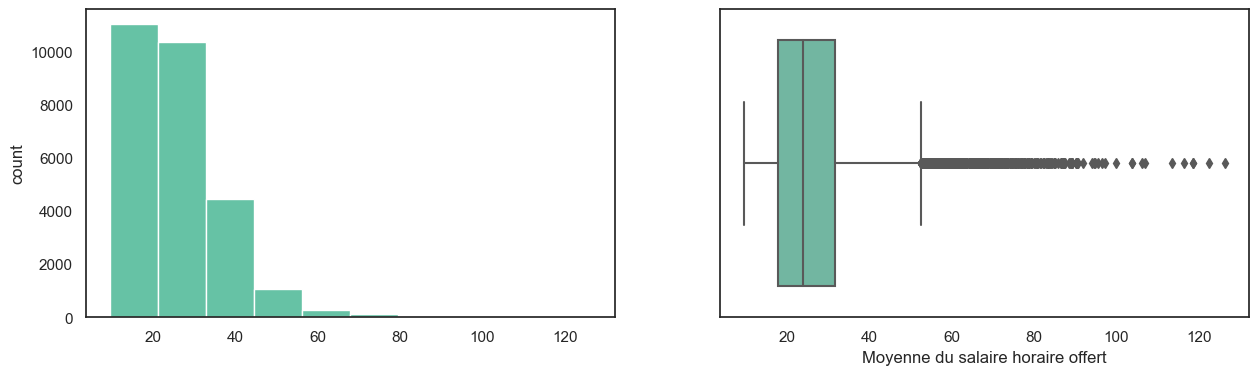

In [37]:
col = 'Moyenne du salaire horaire offert'
print(col)
print('Skew :', round(df_postes_vacants[col].skew(), 2))
plt.figure(figsize = (15, 4))
plt.subplot(1, 2, 1)
df_postes_vacants[col].hist(grid=False)
plt.ylabel('count')
plt.subplot(1, 2, 2)
sns.boxplot(x=df_postes_vacants[col])
plt.show()

La distribution de la moyenne du salaire horaire offert est modale asymétrique positive. 
Elle est inclinée avec une queue vers la droite. 
Selon le boxplot, il y a quelques valeurs aberrantes à l’extrémité droite de la distribution de la variable.

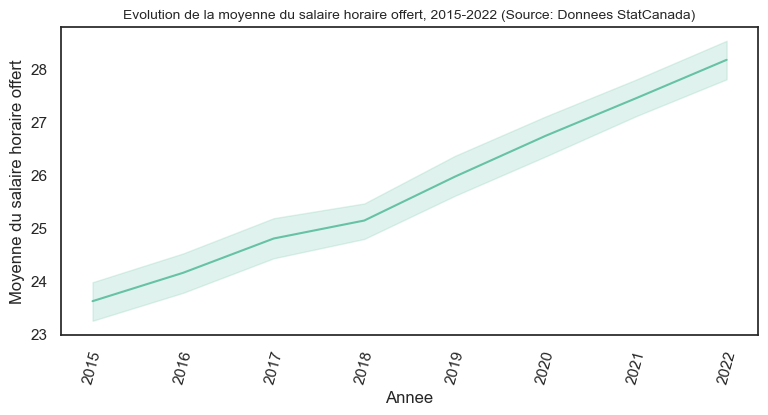

In [38]:
sns.lineplot(data=df_postes_vacants.sort_values(by="Annee"), 
             x="Annee", 
             y='Moyenne du salaire horaire offert',
            markers=True,
            dashes=False)
plt.title(label="Evolution de la moyenne du salaire horaire offert, 2015-2022 (Source: Donnees StatCanada)",
          fontdict={'fontsize':10}, loc='center')
plt.xticks(rotation=75)
plt.show()

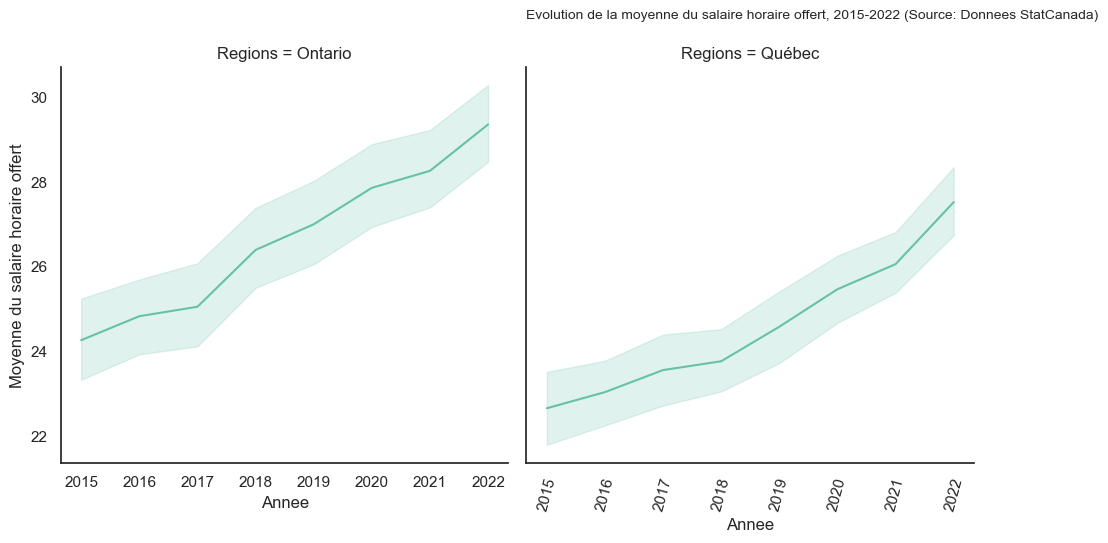

In [39]:
filtre_Ont_Qc=(df_postes_vacants['Regions'].isin(['Ontario','Québec']))
sns.relplot(data=df_postes_vacants[filtre_Ont_Qc],
             x="Annee", 
             y='Moyenne du salaire horaire offert',
             col='Regions',
             kind='line',
             #markers=True, 
            dashes=True
            
            )
plt.title(label='Evolution de la moyenne du salaire horaire offert, 2015-2022 (Source: Donnees StatCanada)',
          fontdict={'fontsize':10}, loc='left',y=1.1)
plt.xticks(rotation=75)
plt.show()

<Figure size 800x1200 with 0 Axes>

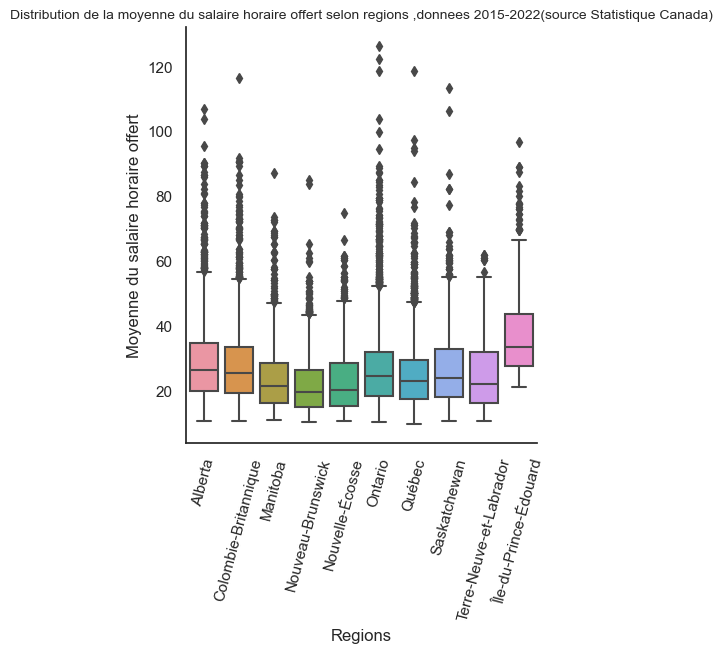

In [40]:
plt.figure(figsize=(8,12))
sns.catplot(data=df_postes_vacants, 
            x="Regions", 
            y="Moyenne du salaire horaire offert", 
            kind="box",
            #palette="pastel",
           dodge=True)
plt.title(label="Distribution de la moyenne du salaire horaire offert selon regions ,donnees 2015-2022(source Statistique Canada)",
          fontdict={'fontsize':10}, loc='center')
plt.xticks(rotation=75)
plt.show()

#### Valeurs aberantes 

 Dans ce qui suit, on va supposer, pour l'exemple, que la base de données contient 0,5% de valeurs aberrantes de toutes sortes. Ce n'est pas exagéré. Cela représente $0,005*27410 \approx 137$ valeurs.

On utilise la méthode de la [forêt d'isolation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) pour détecter et éliminer un maximum de 0,5% des valeurs possiblement aberrantes. 

In [41]:
from sklearn.ensemble import IsolationForest
# Trouvons les valeurs aberrantes; la variable 'outlier' vaut -1 
# pour les valeurs aberrantes et +1 pour les autres.
i_forest = IsolationForest(contamination= 0.005, random_state=42)
df_postes_vacants_=df_postes_vacants
df_postes_vacants_['outliers'] = i_forest.fit(np.array(df_postes_vacants_['Moyenne du salaire horaire offert']).reshape(-1, 1)).predict(np.array(df_postes_vacants_['Moyenne du salaire horaire offert']).reshape(-1, 1))

# Affichons les 15 premières données de la base de données
df_postes_vacants_[df_postes_vacants_['outliers']==-1].head(15)

,Regions,CNP,Annee,Postes vacants,Moyenne du salaire horaire offert,outliers
602,Alberta,Cadres supérieurs/cadres supérieures - adminis...,2020,15.0,80.500000,-1
606,Alberta,Cadres supérieurs/cadres supérieures - commerc...,2018,0.0,86.450000,-1
607,Alberta,Cadres supérieurs/cadres supérieures - commerc...,2019,0.0,71.625000,-1
608,Alberta,Cadres supérieurs/cadres supérieures - commerc...,2021,5.0,81.000000,-1
610,Alberta,Cadres supérieurs/cadres supérieures - constru...,2016,30.0,83.812500,-1
611,Alberta,Cadres supérieurs/cadres supérieures - constru...,2017,20.0,86.583333,-1
613,Alberta,Cadres supérieurs/cadres supérieures - constru...,2019,80.0,106.975000,-1
614,Alberta,Cadres supérieurs/cadres supérieures - constru...,2020,0.0,103.700000,-1
615,Alberta,Cadres supérieurs/cadres supérieures - constru...,2022,5.0,75.425000,-1
619,Alberta,"Cadres supérieurs/cadres supérieures - santé, ...",2018,35.0,74.833333,-1


### Analyse des postes vacants

#### Distribution des postes par année

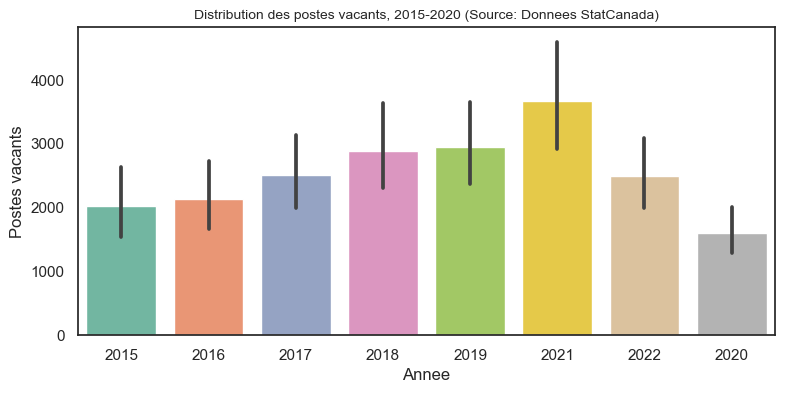

In [42]:
sns.barplot(data=df_postes_vacants, 
             x="Annee", 
             y='Postes vacants'
            )
plt.title(label="Distribution des postes vacants, 2015-2020 (Source: Donnees StatCanada)",
          fontdict={'fontsize':10}, loc='center')
plt.show()

#### Distribution des postes par régions

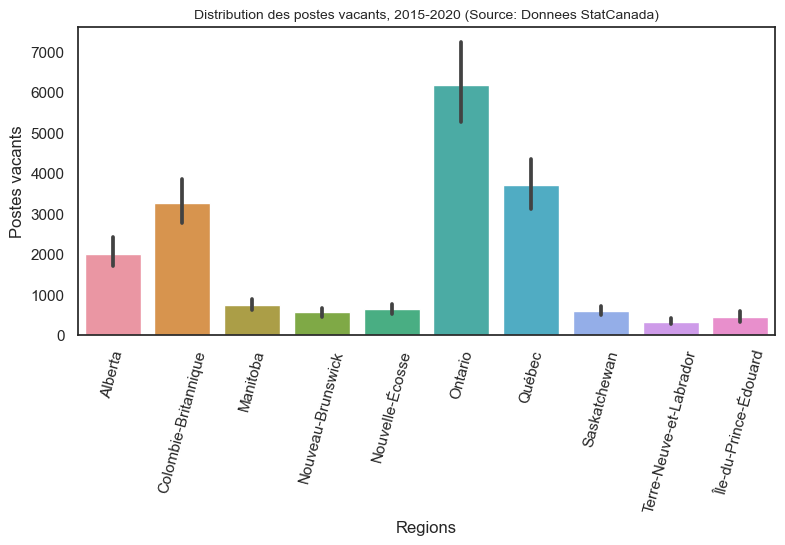

In [43]:
sns.barplot(data=df_postes_vacants, 
             x="Regions", 
             y='Postes vacants'
            )
plt.title(label="Distribution des postes vacants, 2015-2020 (Source: Donnees StatCanada)",
          fontdict={'fontsize':10}, loc='center')
plt.xticks(rotation=75)
plt.show()

* Ontario a le plus grand nombre des postes vacants , suivi de Québec
* Le plus grand nombre des postes vacants a été en 2021, suivi de 2019

In [44]:
df_postes_vacants.shape

(27410, 6)

#### Distribution des postes par CNP

In [47]:
df_postes_vacants['CNP'].head(75).value_counts()

Adjoints administratifs juridiques/adjointes administratives juridiques [1242]                        8
Adjoints administratifs médicaux/adjointes administratives médicales [1243]                           8
Adjoints administratifs/adjointes administratives [1241]                                              8
Adjoints administratifs/adjointes administratives de bureau - général, juridique et médical [124]     8
Adjoints/adjointes de direction [1222]                                                                8
Administrateurs/administratrices - enseignement postsecondaire et formation professionnelle [0421]    8
Administrateurs/administratrices de la paye [1432]                                                    8
Affaires, finance et administration [1]                                                               8
Acheteurs/acheteuses des commerces de détail et de gros [6222]                                        7
Agents/agentes aux achats [1225]                                

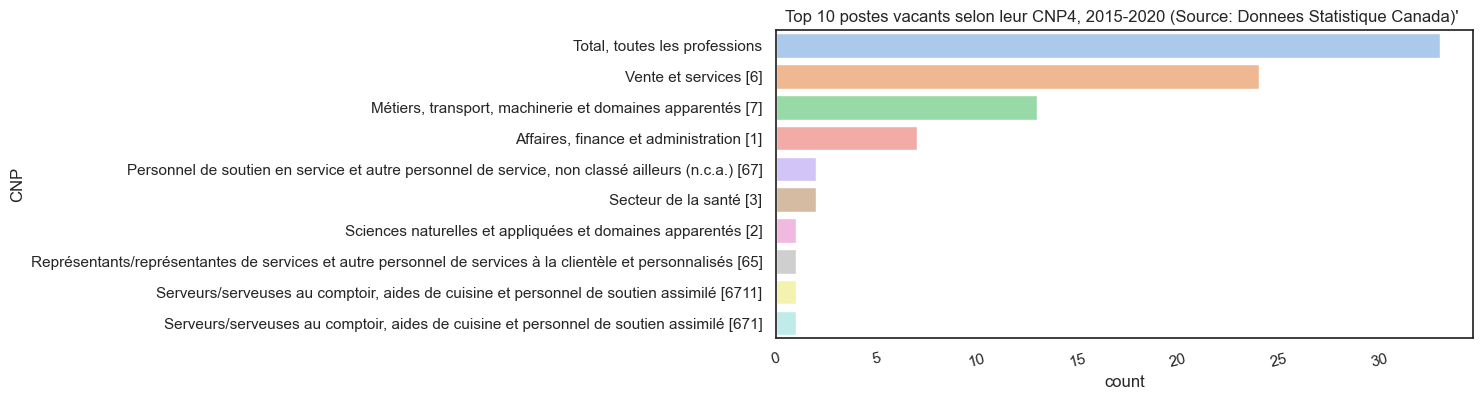

In [48]:
plt.title("Top 10 postes vacants selon leur CNP4, 2015-2020 (Source: Donnees Statistique Canada)' ")
sns.countplot(data=df_postes_vacants.nlargest(85,'Postes vacants'),
              y='CNP',
              #order = df_postes_vacants['CNP'].head(75).value_counts().index,
              palette='pastel')
plt.xticks(rotation=15)
plt.show()

## Exporter to csv

In [49]:
df_postes_vacants.to_csv(r"D:\Daiana\Documents\AEC Intelligence artificielle\Mise en place d'un écosystème d'IA\salary\data\raw\df_postes_vacants", index = False)

### Annexe

In [ ]:
for col in num_cols:
    print(col)
    print('Skew :', round(df_postes_vacants[col].skew(), 2))
    plt.figure(figsize = (15, 4))
    plt.subplot(1, 2, 1)
    df_postes_vacants[col].hist(grid=False)
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_postes_vacants[col])
    plt.show()